# House Price Prediction

```Data/house_price.csv```には、住宅の価格(```SalePrice```)と住宅の関連情報が格納されています。

- このデータを用いて、住宅の価格(```SalePrice```)を予測するモデルを構築、評価しなさい。
- データ中身を確認しながら、適切な特徴量エンジニアリングやモデル選定ための考えもまとめてください。

## Take a Quick Look at the Data Structure

In [135]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [136]:
housing = pd.read_csv("./Data/house_price.csv")
housing.head()
housing=housing.drop("Id",axis=1)

In [137]:
data_types = housing.dtypes
numeric_summary = housing.describe()
summary_df = pd.DataFrame({'Data Type': data_types, 'Mean': numeric_summary.loc['mean'], 'Count': numeric_summary.loc['count'],'Min': numeric_summary.loc['min'], 'Max': numeric_summary.loc['max']})
summary_df["Data Type"]=summary_df["Data Type"].astype(str)
summary_df.head(30)

,Data Type,Mean,Count,Min,Max
1stFlrSF,int64,1162.626712,1460.0,334.0,4692.0
2ndFlrSF,int64,346.992466,1460.0,0.0,2065.0
3SsnPorch,int64,3.409589,1460.0,0.0,508.0
Alley,object,NaN,NaN,NaN,NaN
BedroomAbvGr,int64,2.866438,1460.0,0.0,8.0
BldgType,object,NaN,NaN,NaN,NaN
BsmtCond,object,NaN,NaN,NaN,NaN
BsmtExposure,object,NaN,NaN,NaN,NaN
BsmtFinSF1,int64,443.639726,1460.0,0.0,5644.0
BsmtFinSF2,int64,46.549315,1460.0,0.0,1474.0


### House Price Distribution

予測目標の分布を確認しましょう
- 顕著な正の歪度を持つ
- 尖度を示す

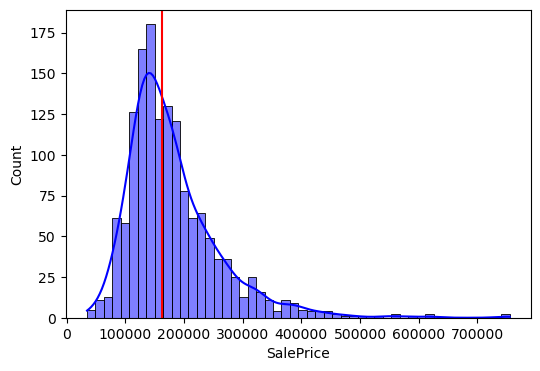

In [138]:
plt.figure(figsize=(6, 4))
sns.histplot(housing['SalePrice'], color='b', bins=50, kde=True)
plt.axvline(x=housing.SalePrice.median(),
            color='red')

In [139]:
print("Skewness: %f" % housing['SalePrice'].skew())
print("Kurtosis: %f" % housing['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Relationship between Sale Price and Other Variables

/var/folders/wm/5xxpvjcj15g89khxd5jwn9200000gn/T/ipykernel_1777/74473714.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = housing.corr()


<AxesSubplot:>

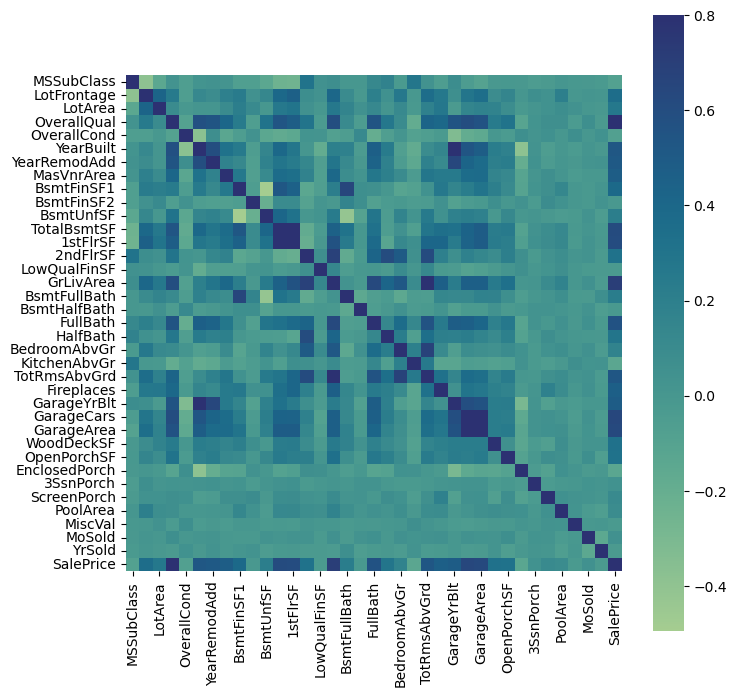

In [140]:
corrmat = housing.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="crest")

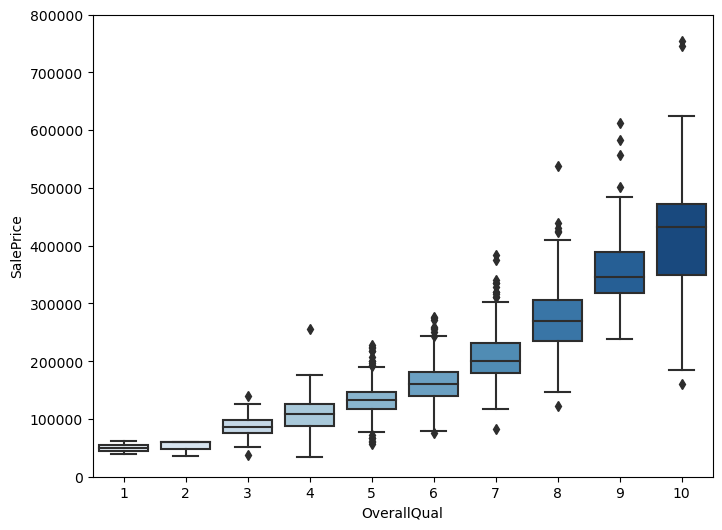

In [141]:
var = 'OverallQual'
data = pd.concat([housing['SalePrice'], housing[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="Blues")
fig.axis(ymin=0, ymax=800000);

<AxesSubplot:xlabel='SalePrice', ylabel='GrLivArea'>

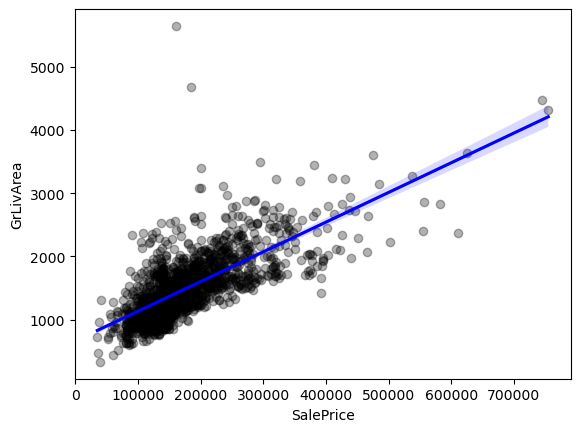

In [142]:
#scatter plot totalbsmtsf/saleprice
var = 'GrLivArea'
data = pd.concat([housing['SalePrice'], housing[var]], axis=1)
sns.regplot(x = "SalePrice", y = var, data = data,
            scatter_kws = {"color": "black", "alpha": 0.3},
            line_kws = {"color": "blue"})

## Data Cleaning

### Missing Data

In [143]:
total = housing.isnull().sum().sort_values(ascending=False)
percent = (housing.isnull().sum()/housing.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [144]:
missing_data.loc[missing_data["Percent"]>0.8, :].index.tolist()

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

- データの20％以上が欠落している(例えば'PoolQC'、'MiscFeature'、'Alley'など）場合は、該当する変数を削除すべきだと考える。

In [145]:
housing=housing.drop(missing_data.loc[missing_data["Percent"]>0.85, :].index.tolist(),axis=1)

In [146]:
data_types = housing.dtypes
numeric_summary = housing.describe()
summary_df = pd.DataFrame({'Data Type': data_types, 'Mean': numeric_summary.loc['mean'], 'Count': numeric_summary.loc['count'],'Min': numeric_summary.loc['min'], 'Max': numeric_summary.loc['max']})
summary_df["Data Type"]=summary_df["Data Type"].astype(str)

### Impute Missing Data

#### Use Median to impute numberic variables

In [162]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [148]:
housing_num=housing[summary_df.loc[summary_df["Data Type"].isin(['int64', 'float64']),:].index]
housing_num[housing_num.isnull()].head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [150]:
missing_data.loc[missing_data["Percent"]>0.85, :].index.tolist()

['PoolQC', 'MiscFeature', 'Alley']

#### Use One-Hot Encoding to transform categorical variables

In [163]:
housing_cat=housing[summary_df.loc[summary_df["Data Type"].isin(['object']),:].index]


In [164]:
housing_cat

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1Fam,TA,No,Unf,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,None,Gilbert,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1456,1Fam,TA,No,ALQ,Rec,Gd,Y,Norm,Norm,SBrkr,...,RL,Stone,NWAmes,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1457,1Fam,Gd,No,GLQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1458,1Fam,TA,Mn,GLQ,Rec,TA,Y,Norm,Norm,FuseA,...,RL,None,NAmes,Y,CompShg,Hip,Normal,WD,Pave,AllPub


In [165]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [166]:
housing_cat=cat_encoder.fit_transform(housing_cat)

#### Combine them into a pipeline

In [185]:
from sklearn.compose import ColumnTransformer
num_attribs = list(summary_df.loc[summary_df["Data Type"].isin(['int64', 'float64']),:].index)
cat_attribs = list(summary_df.loc[summary_df["Data Type"].isin(['object']),:].index)
full_pipeline = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

In [186]:
housing_prepared = full_pipeline.fit_transform(housing.dropna(subset=["SalePrice"]))
target =housing["SalePrice"]

In [187]:
housing_prepared

<1460x293 sparse matrix of type '<class 'numpy.float64'>'
	with 95048 stored elements in Compressed Sparse Row format>

## Preparing Data


In [188]:
#n_bins = 10
#bins = pd.cut(target, bins=n_bins, labels=False)

In [204]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=bins, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(housing_prepared, target, test_size=0.2,random_state=42)

## Train and Validate the Model


In [221]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [222]:
housing_prediction= lin_reg.predict(X_test)
print("lin_rmse:",np.sqrt(mean_squared_error(y_test, housing_prediction)))

lin_rmse: 0.15380220220766208


<AxesSubplot:xlabel='SalePrice'>

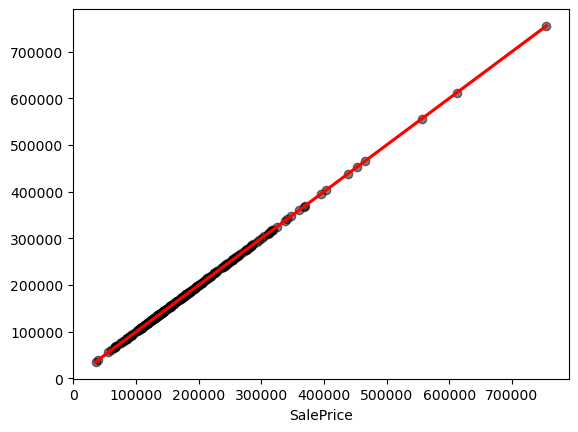

In [223]:
sns.regplot(x = y_test, y = housing_prediction,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

In [224]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [225]:
housing_prediction= tree_reg.predict(X_test)
print("lin_rmse:",np.sqrt(mean_squared_error(y_test, housing_prediction)))

lin_rmse: 15074.439933143294


<AxesSubplot:xlabel='SalePrice'>

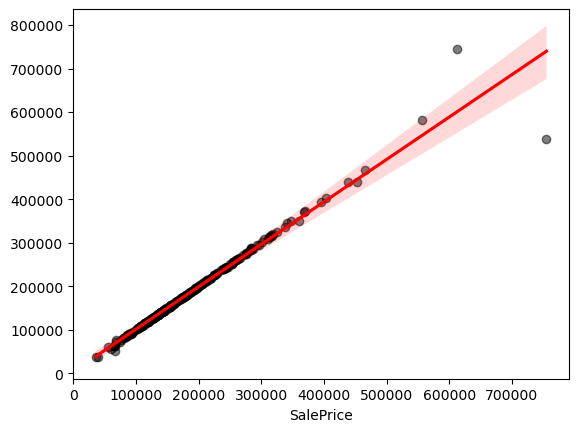

In [226]:
sns.regplot(x = y_test, y = housing_prediction,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})